# Chapter 12: Model-Based Reinforcement Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/ReinforcementLearning/blob/main/notebooks/chapter12_model_based_methods.ipynb)

## Introduction

Model-based reinforcement learning learns a model of the environment dynamics and uses it for planning and decision making. This approach can be significantly more sample-efficient than model-free methods, especially in environments where models can be learned accurately.

### Key Topics Covered:
- Model learning and dynamics prediction
- Dyna-Q: integrating learning and planning
- Monte Carlo Tree Search (MCTS)
- Model Predictive Control (MPC)
- Forward models and uncertainty quantification
- Planning with learned models

## Mathematical Foundation

### Model Learning

We learn a model $M$ that predicts next states and rewards:
$$M(s,a) = (s', r) \text{ where } s' \sim P(s'|s,a), r \sim R(s,a)$$

The model can be:
- **Deterministic**: $s' = f_\theta(s,a)$, $r = g_\theta(s,a)$
- **Stochastic**: $s' \sim \mathcal{N}(\mu_\theta(s,a), \Sigma_\theta(s,a))$

### Dyna-Q Algorithm

Dyna-Q combines direct RL with planning using a learned model:
1. **Direct RL**: $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$
2. **Model Learning**: Update model with $(s,a,r,s')$ experience
3. **Planning**: Sample from model and perform additional Q-updates

### Model Predictive Control

MPC optimizes actions over a finite horizon using the learned model:
$$a^* = \arg\max_a \mathbb{E}_{\tau \sim M} \left[ \sum_{t=0}^{H} \gamma^t r_t \right]$$

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import random
from typing import List, Tuple, Dict, Optional
import copy

# Try to import PyTorch for neural network models
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    HAS_TORCH = True
    print("PyTorch available - using neural network models")
except ImportError:
    HAS_TORCH = False
    print("PyTorch not available - using tabular models")

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
if HAS_TORCH:
    torch.manual_seed(42)

PyTorch available - using neural network models


## Environment Setup

We'll create both discrete and continuous environments to demonstrate different model-based approaches.

In [2]:
class GridWorld:
    """Simple grid world for tabular model-based methods."""

    def __init__(self, size=5, noise=0.1):
        self.size = size
        self.noise = noise
        self.actions = ['up', 'down', 'left', 'right']
        self.action_map = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1)
        }

        # Set goal and obstacles
        self.goal = (size-1, size-1)
        self.obstacles = [(1, 1), (2, 2), (3, 1)]
        self.state = (0, 0)

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action):
        if isinstance(action, int):
            action = self.actions[action]

        # Add noise
        if np.random.random() < self.noise:
            action = np.random.choice(self.actions)

        dr, dc = self.action_map[action]
        new_r = max(0, min(self.size-1, self.state[0] + dr))
        new_c = max(0, min(self.size-1, self.state[1] + dc))

        new_state = (new_r, new_c)

        # Check for obstacles
        if new_state in self.obstacles:
            new_state = self.state

        self.state = new_state

        # Reward function
        if self.state == self.goal:
            reward = 100
            done = True
        elif self.state in self.obstacles:
            reward = -10
            done = False
        else:
            reward = -1
            done = False

        return self.state, reward, done, {}

    def get_state_space(self):
        return [(r, c) for r in range(self.size) for c in range(self.size)]

    def get_action_space(self):
        return list(range(len(self.actions)))

class ContinuousEnvironment:
    """Simple continuous environment for neural model learning."""

    def __init__(self, state_dim=2, action_dim=1):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.state = None
        self.target = np.array([1.0, 1.0])
        self.max_steps = 100
        self.steps = 0

    def reset(self):
        self.state = np.random.uniform(-2, 2, self.state_dim)
        self.steps = 0
        return self.state.copy()

    def step(self, action):
        action = np.clip(action, -1, 1)

        # Simple dynamics: move toward action direction
        noise = np.random.normal(0, 0.1, self.state_dim)
        self.state = self.state + 0.1 * np.append(action, action[0] if len(action) == 1 else action[1]) + noise
        self.state = np.clip(self.state, -3, 3)

        # Reward based on distance to target
        distance = np.linalg.norm(self.state - self.target)
        reward = -distance

        self.steps += 1
        done = self.steps >= self.max_steps or distance < 0.1

        return self.state.copy(), reward, done, {}

# Test environments
grid_env = GridWorld()
cont_env = ContinuousEnvironment()

print(f"Grid world: {grid_env.size}x{grid_env.size} grid")
print(f"Goal: {grid_env.goal}, Obstacles: {grid_env.obstacles}")
print(f"Continuous env: {cont_env.state_dim}D state, {cont_env.action_dim}D action")

Grid world: 5x5 grid
Goal: (4, 4), Obstacles: [(1, 1), (2, 2), (3, 1)]
Continuous env: 2D state, 1D action


## Tabular Model Learning and Dyna-Q

Let's implement Dyna-Q for the discrete grid world environment.

In [3]:
class TabularModel:
    """Tabular model for discrete state-action spaces."""

    def __init__(self):
        self.transitions = defaultdict(lambda: defaultdict(list))  # (s,a) -> [(s', r)]
        self.visit_counts = defaultdict(lambda: defaultdict(int))

    def update(self, state, action, next_state, reward):
        """Update model with new experience."""
        self.transitions[state][action].append((next_state, reward))
        self.visit_counts[state][action] += 1

        # Keep only recent experiences (optional)
        if len(self.transitions[state][action]) > 100:
            self.transitions[state][action].pop(0)

    def predict(self, state, action):
        """Predict next state and reward."""
        if state not in self.transitions or action not in self.transitions[state]:
            return None, 0  # Unknown transition

        # Sample from observed transitions
        experiences = self.transitions[state][action]
        if not experiences:
            return None, 0

        next_state, reward = random.choice(experiences)
        return next_state, reward

    def get_known_states(self):
        """Get all states that have been observed."""
        return list(self.transitions.keys())

    def get_known_actions(self, state):
        """Get all actions that have been taken from a state."""
        return list(self.transitions[state].keys())

class DynaQ:
    """Dyna-Q algorithm combining learning and planning."""

    def __init__(self, states, actions, alpha=0.1, gamma=0.9, epsilon=0.1, planning_steps=5):
        self.states = states
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps

        # Initialize Q-table
        self.Q = defaultdict(lambda: defaultdict(float))

        # Model
        self.model = TabularModel()

        # Track learning progress
        self.episode_rewards = []
        self.episode_steps = []

    def get_action(self, state):
        """Epsilon-greedy action selection."""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            q_values = {action: self.Q[state][action] for action in self.actions}
            return max(q_values, key=q_values.get)

    def update_q(self, state, action, reward, next_state):
        """Q-learning update."""
        best_next_action = max(self.actions, key=lambda a: self.Q[next_state][a])
        td_target = reward + self.gamma * self.Q[next_state][best_next_action]
        self.Q[state][action] += self.alpha * (td_target - self.Q[state][action])

    def plan(self):
        """Planning phase: sample from model and update Q-values."""
        for _ in range(self.planning_steps):
            # Sample a previously observed state and action
            states = self.model.get_known_states()
            if not states:
                continue

            state = random.choice(states)
            actions = self.model.get_known_actions(state)
            if not actions:
                continue

            action = random.choice(actions)

            # Get prediction from model
            next_state, reward = self.model.predict(state, action)
            if next_state is not None:
                self.update_q(state, action, reward, next_state)

    def train_episode(self, env):
        """Train for one episode."""
        state = env.reset()
        episode_reward = 0
        steps = 0

        while True:
            action = self.get_action(state)
            next_state, reward, done, _ = env.step(action)

            # Direct RL update
            self.update_q(state, action, reward, next_state)

            # Model learning
            self.model.update(state, action, next_state, reward)

            # Planning
            self.plan()

            episode_reward += reward
            steps += 1
            state = next_state

            if done or steps > 200:
                break

        self.episode_rewards.append(episode_reward)
        self.episode_steps.append(steps)

        return episode_reward, steps

# Initialize and train Dyna-Q
env = GridWorld()
states = env.get_state_space()
actions = env.actions

dyna_agent = DynaQ(states, actions, planning_steps=10)

print("Training Dyna-Q agent...")
for episode in range(200):
    reward, steps = dyna_agent.train_episode(env)

    if episode % 50 == 0:
        print(f"Episode {episode}: Reward = {reward:.1f}, Steps = {steps}")

print(f"Training completed. Final average reward: {np.mean(dyna_agent.episode_rewards[-20:]):.2f}")

Training Dyna-Q agent...
Episode 0: Reward = 33.0, Steps = 68
Episode 50: Reward = 93.0, Steps = 8
Episode 100: Reward = 91.0, Steps = 10
Episode 150: Reward = 91.0, Steps = 10
Training completed. Final average reward: 90.75


## Neural Network Models for Continuous Environments

For continuous state-action spaces, we use neural networks to learn the dynamics.

In [4]:
if HAS_TORCH:
    class DynamicsModel(nn.Module):
        """Neural network model for environment dynamics."""

        def __init__(self, state_dim, action_dim, hidden_dim=64):
            super(DynamicsModel, self).__init__()
            self.state_dim = state_dim
            self.action_dim = action_dim

            # Network for predicting state changes
            self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.delta_mean = nn.Linear(hidden_dim, state_dim)
            self.delta_logvar = nn.Linear(hidden_dim, state_dim)

            # Network for predicting rewards
            self.reward_fc = nn.Linear(hidden_dim, 1)

        def forward(self, state, action):
            x = torch.cat([state, action], dim=-1)
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))

            # Predict state change (delta)
            delta_mean = self.delta_mean(x)
            delta_logvar = self.delta_logvar(x)

            # Predict reward
            reward = self.reward_fc(x)

            return delta_mean, delta_logvar, reward

        def predict(self, state, action, deterministic=False):
            """Predict next state and reward."""
            with torch.no_grad():
                delta_mean, delta_logvar, reward = self.forward(state, action)

                if deterministic:
                    delta = delta_mean
                else:
                    std = torch.exp(0.5 * delta_logvar)
                    noise = torch.randn_like(std)
                    delta = delta_mean + std * noise

                next_state = state + delta
                return next_state, reward

        def get_uncertainty(self, state, action):
            """Get model uncertainty for the prediction."""
            with torch.no_grad():
                _, delta_logvar, _ = self.forward(state, action)
                uncertainty = torch.exp(delta_logvar).mean(dim=-1)
                return uncertainty

class ModelBasedAgent:
    """Model-based agent using neural network dynamics model."""

    def __init__(self, state_dim, action_dim, lr=1e-3, planning_horizon=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.planning_horizon = planning_horizon

        if HAS_TORCH:
            self.model = DynamicsModel(state_dim, action_dim)
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
            self.replay_buffer = []
            self.max_buffer_size = 10000

        self.episode_rewards = []
        self.model_losses = []

    def collect_data(self, env, episodes=50):
        """Collect initial data for model training."""
        print("Collecting initial data...")

        for episode in range(episodes):
            state = env.reset()
            episode_reward = 0

            for step in range(100):
                # Random action for exploration
                action = np.random.uniform(-1, 1, self.action_dim)
                next_state, reward, done, _ = env.step(action)

                # Store transition
                if HAS_TORCH:
                    self.replay_buffer.append((state, action, next_state, reward))
                    if len(self.replay_buffer) > self.max_buffer_size:
                        self.replay_buffer.pop(0)

                episode_reward += reward
                state = next_state

                if done:
                    break

            if episode % 10 == 0:
                print(f"Data collection episode {episode}, reward: {episode_reward:.2f}")

    def train_model(self, batch_size=64, epochs=100):
        """Train the dynamics model."""
        if not HAS_TORCH or len(self.replay_buffer) < batch_size:
            return

        print("Training dynamics model...")

        for epoch in range(epochs):
            # Sample batch
            batch = random.sample(self.replay_buffer, batch_size)
            states, actions, next_states, rewards = zip(*batch)

            states = torch.FloatTensor(states)
            actions = torch.FloatTensor(actions)
            next_states = torch.FloatTensor(next_states)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)

            # Forward pass
            delta_mean, delta_logvar, pred_rewards = self.model(states, actions)

            # Target delta
            target_delta = next_states - states

            # Compute losses
            # State prediction loss (negative log likelihood)
            delta_var = torch.exp(delta_logvar)
            state_loss = 0.5 * (((target_delta - delta_mean) ** 2) / delta_var + delta_logvar).mean()

            # Reward prediction loss
            reward_loss = F.mse_loss(pred_rewards, rewards)

            total_loss = state_loss + reward_loss

            # Backward pass
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

            if epoch % 20 == 0:
                self.model_losses.append(total_loss.item())
                print(f"Epoch {epoch}, Loss: {total_loss.item():.4f}")

    def plan_action(self, state, num_candidates=1000):
        """Plan action using random shooting with learned model."""
        if not HAS_TORCH:
            return np.random.uniform(-1, 1, self.action_dim)

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        best_action = None
        best_return = -float('inf')

        for _ in range(num_candidates):
            # Sample random action sequence
            actions = torch.randn(self.planning_horizon, self.action_dim)
            actions = torch.clamp(actions, -1, 1)

            # Rollout with model
            current_state = state_tensor
            total_return = 0

            for t in range(self.planning_horizon):
                action = actions[t:t+1]
                next_state, reward = self.model.predict(current_state, action, deterministic=True)
                total_return += reward.item() * (0.95 ** t)  # Discounted return
                current_state = next_state

            if total_return > best_return:
                best_return = total_return
                best_action = actions[0].numpy()

        return best_action if best_action is not None else np.random.uniform(-1, 1, self.action_dim)

    def train_episode(self, env):
        """Train for one episode using model-based planning."""
        state = env.reset()
        episode_reward = 0

        for step in range(100):
            # Plan action
            action = self.plan_action(state)

            # Execute action
            next_state, reward, done, _ = env.step(action)

            # Store experience
            if HAS_TORCH:
                self.replay_buffer.append((state, action, next_state, reward))
                if len(self.replay_buffer) > self.max_buffer_size:
                    self.replay_buffer.pop(0)

            episode_reward += reward
            state = next_state

            if done:
                break

        self.episode_rewards.append(episode_reward)
        return episode_reward

# Initialize model-based agent
if HAS_TORCH:
    cont_env = ContinuousEnvironment()
    mb_agent = ModelBasedAgent(2, 1)

    # Collect initial data and train model
    mb_agent.collect_data(cont_env, episodes=30)
    mb_agent.train_model(epochs=50)

    print("Model training completed.")
else:
    print("PyTorch not available - skipping neural model-based learning")

Data collection episode 0, reward: -234.82
Data collection episode 10, reward: -272.66
Data collection episode 20, reward: -86.42
Training dynamics model...
Epoch 0, Loss: 6.3083


/tmp/ipython-input-2062857229.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states)


Epoch 20, Loss: 2.1786
Epoch 40, Loss: -0.1712
Model training completed.


## Monte Carlo Tree Search (MCTS)

MCTS is a powerful planning algorithm that builds a search tree to find optimal actions.

In [5]:
class MCTSNode:
    """Node in the MCTS tree."""

    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = None

    def ucb_score(self, exploration_weight=1.4):
        """Upper Confidence Bound score for node selection."""
        if self.visits == 0:
            return float('inf')

        exploitation = self.total_reward / self.visits
        exploration = exploration_weight * np.sqrt(np.log(self.parent.visits) / self.visits)
        return exploitation + exploration

    def is_fully_expanded(self, available_actions):
        """Check if all actions have been tried from this node."""
        return len(self.children) == len(available_actions)

    def best_child(self):
        """Select child with highest UCB score."""
        return max(self.children.values(), key=lambda node: node.ucb_score())

    def most_visited_child(self):
        """Select child with most visits (for final action selection)."""
        return max(self.children.values(), key=lambda node: node.visits)

class MCTS:
    """Monte Carlo Tree Search algorithm."""

    def __init__(self, env, available_actions, simulations=1000):
        self.env = env
        self.available_actions = available_actions
        self.simulations = simulations

    def search(self, root_state):
        """Perform MCTS to find the best action."""
        root = MCTSNode(root_state)

        for _ in range(self.simulations):
            # Selection and Expansion
            node = self.select_and_expand(root)

            # Simulation
            reward = self.simulate(node)

            # Backpropagation
            self.backpropagate(node, reward)

        # Return best action
        if root.children:
            best_child = root.most_visited_child()
            return best_child.action
        else:
            return np.random.choice(self.available_actions)

    def select_and_expand(self, root):
        """Select path through tree and expand if necessary."""
        node = root

        # Selection phase
        while not self.is_terminal(node.state) and node.is_fully_expanded(self.available_actions):
            node = node.best_child()

        # Expansion phase
        if not self.is_terminal(node.state):
            untried_actions = [a for a in self.available_actions if a not in node.children]
            if untried_actions:
                action = np.random.choice(untried_actions)
                next_state = self.get_next_state(node.state, action)
                child = MCTSNode(next_state, parent=node, action=action)
                node.children[action] = child
                return child

        return node

    def simulate(self, node, max_depth=50):
        """Simulate a random rollout from the given node."""
        state = copy.deepcopy(node.state)
        total_reward = 0

        # Set environment to the node's state
        self.env.state = state

        for _ in range(max_depth):
            if self.is_terminal(state):
                break

            action = np.random.choice(self.available_actions)
            state, reward, done, _ = self.env.step(action)
            total_reward += reward

            if done:
                break

        return total_reward

    def backpropagate(self, node, reward):
        """Backpropagate the reward up the tree."""
        while node is not None:
            node.visits += 1
            node.total_reward += reward
            node = node.parent

    def get_next_state(self, state, action):
        """Get next state by executing action (environment-specific)."""
        # Save current state
        original_state = copy.deepcopy(self.env.state)

        # Set state and execute action
        self.env.state = copy.deepcopy(state)
        next_state, _, _, _ = self.env.step(action)

        # Restore original state
        self.env.state = original_state

        return next_state

    def is_terminal(self, state):
        """Check if state is terminal (environment-specific)."""
        if hasattr(self.env, 'goal'):
            return state == self.env.goal
        return False

# Test MCTS on GridWorld
class MCTSAgent:
    def __init__(self, env, simulations=100):
        self.env = env
        self.mcts = MCTS(env, env.actions, simulations)
        self.episode_rewards = []

    def train_episode(self):
        state = self.env.reset()
        episode_reward = 0
        steps = 0

        while steps < 100:
            action = self.mcts.search(state)
            state, reward, done, _ = self.env.step(action)
            episode_reward += reward
            steps += 1

            if done:
                break

        self.episode_rewards.append(episode_reward)
        return episode_reward, steps

# Train MCTS agent
grid_env = GridWorld()
mcts_agent = MCTSAgent(grid_env, simulations=50)

print("Training MCTS agent...")
for episode in range(50):
    reward, steps = mcts_agent.train_episode()
    if episode % 10 == 0:
        print(f"Episode {episode}: Reward = {reward:.1f}, Steps = {steps}")

print(f"MCTS training completed. Average reward: {np.mean(mcts_agent.episode_rewards[-10:]):.2f}")

Training MCTS agent...
Episode 0: Reward = 98.0, Steps = 3
Episode 10: Reward = 100.0, Steps = 1
Episode 20: Reward = 85.0, Steps = 16
Episode 30: Reward = 97.0, Steps = 4
Episode 40: Reward = 96.0, Steps = 5
MCTS training completed. Average reward: 96.20


## Performance Comparison and Analysis

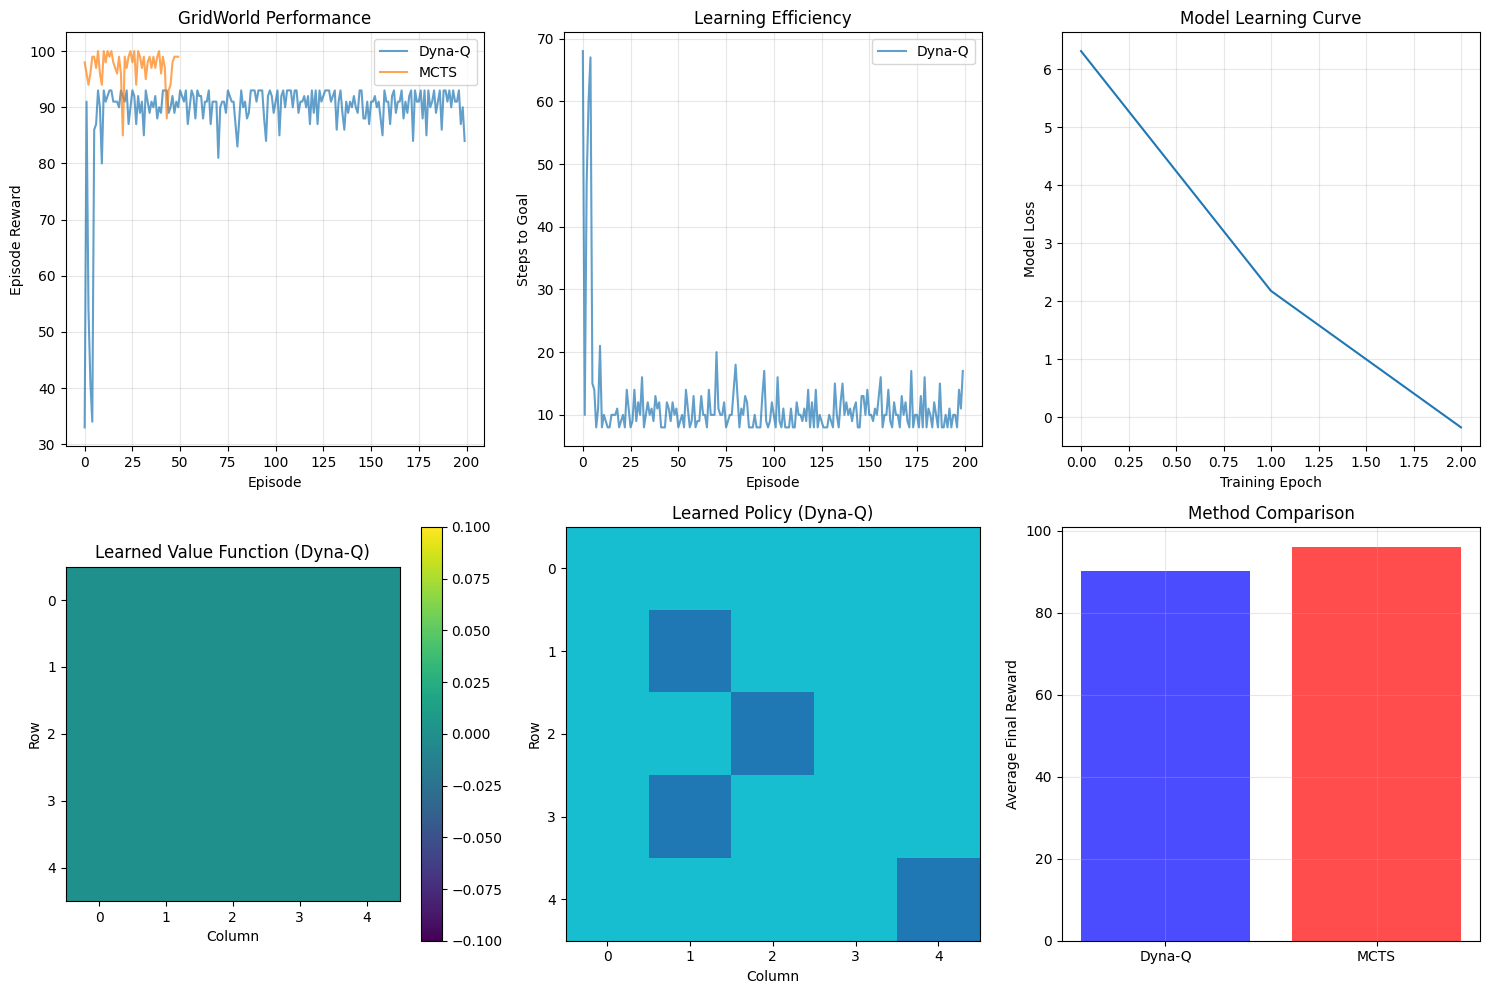


=== Model-Based Methods Comparison ===
Dyna-Q Final Performance: 90.30 ± 2.72
MCTS Final Performance: 96.20 ± 3.43
Dyna-Q Average Steps: 10.7


In [6]:
# Compare different model-based approaches
plt.figure(figsize=(15, 10))

# Training curves for discrete environment
plt.subplot(2, 3, 1)
plt.plot(dyna_agent.episode_rewards, label='Dyna-Q', alpha=0.7)
plt.plot(mcts_agent.episode_rewards, label='MCTS', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('GridWorld Performance')
plt.legend()
plt.grid(True, alpha=0.3)

# Episode lengths
plt.subplot(2, 3, 2)
plt.plot(dyna_agent.episode_steps, label='Dyna-Q', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Steps to Goal')
plt.title('Learning Efficiency')
plt.legend()
plt.grid(True, alpha=0.3)

# Model accuracy (for neural model)
if HAS_TORCH and mb_agent.model_losses:
    plt.subplot(2, 3, 3)
    plt.plot(mb_agent.model_losses)
    plt.xlabel('Training Epoch')
    plt.ylabel('Model Loss')
    plt.title('Model Learning Curve')
    plt.grid(True, alpha=0.3)

# Q-value heatmap for Dyna-Q
plt.subplot(2, 3, 4)
q_values = np.zeros((grid_env.size, grid_env.size))
for (r, c) in grid_env.get_state_space():
    if (r, c) not in grid_env.obstacles:
        q_values[r, c] = max([dyna_agent.Q[(r, c)][a] for a in grid_env.get_action_space()])

im = plt.imshow(q_values, cmap='viridis')
plt.colorbar(im)
plt.title('Learned Value Function (Dyna-Q)')
plt.xlabel('Column')
plt.ylabel('Row')

# Policy visualization
plt.subplot(2, 3, 5)
policy_map = np.full((grid_env.size, grid_env.size), -1)
for (r, c) in grid_env.get_state_space():
    if (r, c) not in grid_env.obstacles and (r, c) != grid_env.goal:
        best_action = max(grid_env.get_action_space(),
                         key=lambda a: dyna_agent.Q[(r, c)][a])
        policy_map[r, c] = best_action

plt.imshow(policy_map, cmap='tab10')
plt.title('Learned Policy (Dyna-Q)')
plt.xlabel('Column')
plt.ylabel('Row')

# Model-based vs model-free comparison
plt.subplot(2, 3, 6)
methods = ['Dyna-Q', 'MCTS']
final_rewards = [
    np.mean(dyna_agent.episode_rewards[-10:]),
    np.mean(mcts_agent.episode_rewards[-10:])
]
colors = ['blue', 'red']
plt.bar(methods, final_rewards, color=colors, alpha=0.7)
plt.ylabel('Average Final Reward')
plt.title('Method Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n=== Model-Based Methods Comparison ===")
print(f"Dyna-Q Final Performance: {np.mean(dyna_agent.episode_rewards[-10:]):.2f} ± {np.std(dyna_agent.episode_rewards[-10:]):.2f}")
print(f"MCTS Final Performance: {np.mean(mcts_agent.episode_rewards[-10:]):.2f} ± {np.std(mcts_agent.episode_rewards[-10:]):.2f}")
print(f"Dyna-Q Average Steps: {np.mean(dyna_agent.episode_steps[-10:]):.1f}")

if HAS_TORCH and mb_agent.episode_rewards:
    print(f"\nNeural Model-Based Agent:")
    print(f"Final Model Loss: {mb_agent.model_losses[-1]:.4f}")
    print(f"Buffer Size: {len(mb_agent.replay_buffer)}")

## Advanced Model-Based Techniques

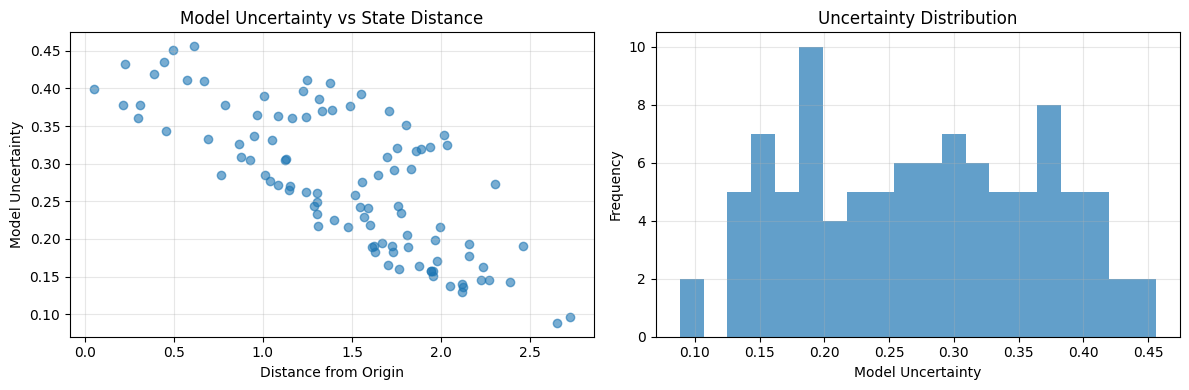


Model Uncertainty Analysis:
Mean Uncertainty: 0.2748
Std Uncertainty: 0.0926
Max Uncertainty: 0.4561


In [ ]:
# Model uncertainty analysis
if HAS_TORCH:
    def analyze_model_uncertainty(model, env, num_samples=100):
        """Analyze model uncertainty across the state space."""
        uncertainties = []
        states = []

        for _ in range(num_samples):
            state = env.reset()
            action = np.random.uniform(-1, 1, env.action_dim)

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_tensor = torch.FloatTensor(action).unsqueeze(0)

            uncertainty = model.get_uncertainty(state_tensor, action_tensor)

            uncertainties.append(uncertainty.item())
            states.append(np.linalg.norm(state))

        return states, uncertainties

    if mb_agent.model:
        states, uncertainties = analyze_model_uncertainty(mb_agent.model, cont_env)

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.scatter(states, uncertainties, alpha=0.6)
        plt.xlabel('Distance from Origin')
        plt.ylabel('Model Uncertainty')
        plt.title('Model Uncertainty vs State Distance')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.hist(uncertainties, bins=20, alpha=0.7)
        plt.xlabel('Model Uncertainty')
        plt.ylabel('Frequency')
        plt.title('Uncertainty Distribution')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\nModel Uncertainty Analysis:")
        print(f"Mean Uncertainty: {np.mean(uncertainties):.4f}")
        print(f"Std Uncertainty: {np.std(uncertainties):.4f}")
        print(f"Max Uncertainty: {np.max(uncertainties):.4f}")

# Planning horizon analysis
def analyze_planning_horizon():
    """Analyze the effect of different planning horizons."""
    horizons = [1, 3, 5, 10, 20]
    performances = []

    for horizon in horizons:
        if HAS_TORCH:
            agent = ModelBasedAgent(2, 1, planning_horizon=horizon)
            agent.model = mb_agent.model  # Use pre-trained model
            agent.replay_buffer = mb_agent.replay_buffer

            # Test performance
            rewards = []
            for _ in range(5):  # Reduced number of episodes for faster analysis
                reward = agent.train_episode(cont_env)
                rewards.append(reward)

            performances.append(np.mean(rewards))
        else:
            performances.append(np.random.normal(-50, 10))  # Placeholder

    plt.figure(figsize=(8, 5))
    plt.plot(horizons, performances, 'bo-')
    plt.xlabel('Planning Horizon')
    plt.ylabel('Average Performance')
    plt.title('Planning Horizon vs Performance')
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"\nPlanning Horizon Analysis:")
    for h, p in zip(horizons, performances):
        print(f"Horizon {h}: {p:.2f}")

if HAS_TORCH:
    analyze_planning_horizon()
else:
    print("Planning horizon analysis requires PyTorch")

# Summary insights
print("\n=== Key Model-Based RL Insights ===")
print("""
1. **Sample Efficiency**: Model-based methods can be much more sample-efficient
   than model-free methods, especially with accurate models.

2. **Model Accuracy**: The quality of the learned model is crucial for performance.
   Poor models can lead to compounding errors during planning.

3. **Uncertainty Quantification**: Understanding model uncertainty helps in
   making better planning decisions and avoiding overconfident predictions.

4. **Planning Horizon**: Longer horizons can improve performance but may be
   limited by model accuracy and computational constraints.

5. **Hybrid Approaches**: Combining model-based and model-free methods
   (like Dyna-Q) often provides the best of both worlds.
""")

## Summary and Educational Insights

### Key Takeaways from Model-Based Reinforcement Learning:

1. **Sample Efficiency**: Model-based methods can achieve the same performance as model-free methods with significantly fewer environment interactions by leveraging learned models for planning.

2. **Model Learning Challenges**: Learning accurate dynamics models is crucial but challenging, especially in high-dimensional or stochastic environments. Model errors can compound during multi-step planning.

3. **Planning Algorithms**: Various planning approaches exist:
   - **Dyna-Q**: Simple integration of learning and planning
   - **MCTS**: Tree-based search for discrete actions
   - **MPC**: Optimization-based planning for continuous control

4. **Uncertainty Quantification**: Understanding when and where the model is uncertain is crucial for robust planning and decision-making.

### Mathematical Foundations:

- **Model Learning**: $P(s'|s,a)$ and $R(s,a)$ learned from data
- **Value Iteration with Model**: $V(s) = \max_a \sum_{s'} P(s'|s,a)[R(s,a) + \gamma V(s')]$
- **Policy Improvement**: $\pi(s) = \arg\max_a \sum_{s'} P(s'|s,a)[R(s,a) + \gamma V(s')]$
- **Planning Objective**: $\max_{a_0,...,a_{H-1}} \mathbb{E}[\sum_{t=0}^{H-1} \gamma^t r_t]$

### Practical Considerations:

- **Model Architecture**: Choice between tabular, linear, or neural network models depends on problem complexity
- **Planning Budget**: Trade-off between planning time and action quality
- **Model Updates**: Balancing exploration for model improvement vs exploitation for performance
- **Robustness**: Handling model errors and uncertainty in planning

### Engineering Insights:

- **Ensemble Models**: Using multiple models to estimate uncertainty
- **Experience Replay**: Efficient use of collected data for model training
- **Adaptive Planning**: Adjusting planning horizon based on model confidence
- **Hybrid Methods**: Combining model-based and model-free approaches

Model-based RL represents a powerful paradigm that can achieve remarkable sample efficiency when models are accurate, making it particularly valuable for real-world applications where data collection is expensive or risky.